In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,LSTM
from tensorflow.keras import Sequential
from keras.models import Sequential
import pandas_datareader as pdr
from pandas_datareader import data, wb

Using TensorFlow backend.


In [2]:
#df = pd.read_csv('Downloads/AAL.csv')
df = pdr.get_data_yahoo('AAL', start = '2015-04-01', end = '2021-02-22')
#df.drop(['Volume','Open','High','Low','Adj Close'],axis=1,inplace=True)
#df["Date"] = pd.to_datetime(df['Date'], format='%Y.%m.%d')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-04-01,51.380001,50.110001,51.099998,50.439999,15191500.0,47.888901
2015-04-02,50.849998,49.150002,50.480000,49.180000,14109800.0,46.692623
2015-04-06,48.689999,47.669998,48.349998,48.080002,13323400.0,45.648262
2015-04-07,48.799999,47.490002,48.299999,47.500000,9393200.0,45.097588
2015-04-08,49.090000,47.730000,47.799999,48.740002,11180000.0,46.274883
...,...,...,...,...,...,...
2021-02-16,17.900000,17.510000,17.629999,17.820000,33507900.0,17.820000
2021-02-17,18.340000,17.480000,17.690001,17.990000,35475700.0,17.990000
2021-02-18,17.980000,17.450001,17.830000,17.709999,26269700.0,17.709999


In [3]:
data = df.filter(['Close'])
dataset = data.values

In [4]:
ts = df.groupby("Date")["Close"].sum().rename("Trend")

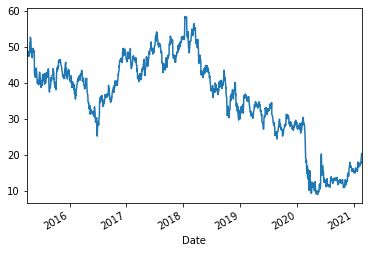

In [5]:
ts.plot()

In [6]:
train_data_length = math.ceil(len(dataset)* 0.8)
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

In [7]:
train_data = scaled_data[0:train_data_length, : ]
x_train = []
y_train = []

for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

[array([0.837548  , 0.81205744, 0.78980378, 0.77806998, 0.80315599,
       0.7849484 , 0.78272301, 0.78393688, 0.77645149, 0.78312764,
       0.79304068, 0.79202908, 0.82379117, 0.85616022, 0.85696946,
       0.85798098, 0.88347154, 0.8664778 , 0.85272097, 0.80598827,
       0.79405219, 0.81630585, 0.80740441, 0.76815694, 0.76896618,
       0.80962979, 0.80922517, 0.82156586, 0.8053813 , 0.79809834,
       0.8047744 , 0.80173978, 0.80841592, 0.78515067, 0.68824602,
       0.67630994, 0.67914222, 0.65790007, 0.67165691, 0.66619463,
       0.67428683, 0.7109043 , 0.70281202, 0.68966215, 0.67024069,
       0.66113697, 0.62350799, 0.63301641, 0.63503944, 0.62674489,
       0.64070399, 0.6277564 , 0.61582033, 0.62391261, 0.62593564,
       0.65790007, 0.68763904, 0.68156987, 0.67165691, 0.67165691])]
[0.6554723414872452]

[array([0.837548  , 0.81205744, 0.78980378, 0.77806998, 0.80315599,
       0.7849484 , 0.78272301, 0.78393688, 0.77645149, 0.78312764,
       0.79304068, 0.79202908, 0.823

In [8]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1128, 60, 1)

In [9]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam',loss = 'mean_squared_error')
model.fit(x_train,y_train,batch_size=1,epochs=1)

Epoch 1/1
1128/1128 [==============================] - 59s 52ms/step - loss: 0.0037


In [10]:
test_data = scaled_data[train_data_length-60:, :]
x_test = []
y_test = dataset[train_data_length:, :]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [11]:
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [12]:
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.6299200186858307

/Users/sampathgubbala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


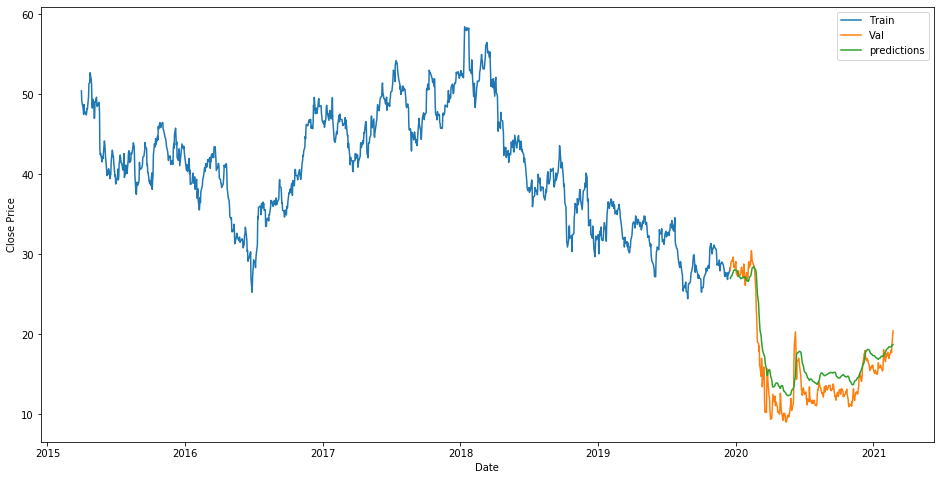

In [13]:
train = data[:train_data_length]
valid = data[train_data_length:]
valid['predictions']= predictions
plt.figure(figsize = (16,8))
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train['Close'])
plt.plot(valid[['Close','predictions']])
plt.legend(['Train','Val','predictions'])
plt.show()

In [14]:
valid

,Close,predictions
Date,,
2019-12-18,28.000000,27.002714
2019-12-19,28.549999,27.096069
2019-12-20,29.040001,27.227602
2019-12-23,29.299999,27.409512
2019-12-24,29.180000,27.619684
...,...,...
2021-02-16,17.820000,18.421993
2021-02-17,17.990000,18.460064
2021-02-18,17.709999,18.534122


In [15]:
df_2 = df.filter(['Close']) 
last_60days = df_2[-60: ].values 
last_60days_scaled = scaler.transform(last_60days)

In [16]:
X_test = []
X_test.append(last_60days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [17]:
pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[19.038952]]
